In [3]:
import os
#import nctoolkit as nc
import netCDF4 as nc
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, osr
import rasterio
from rasterio.transform import from_origin

In [4]:
def read_netcdf(file_path, var_name):
    dataset = nc.Dataset(file_path)
    data = dataset.variables[var_name][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    time = dataset.variables['time'][:]
    dataset.close()
    return data, lats, lons, time

def aggregate_to_annual(data):
    # Check if data has at least 12 months of data
    if data.shape[0] < 12:
        raise ValueError("Data does not have enough months to aggregate into years.")
    # Assuming data is monthly, reshape to (years, months, lat, lon)
    years = data.shape[0] // 12
    data_reshaped = data[:years * 12].reshape((years, 12, *data.shape[1:]))
    annual_data = np.nansum(data_reshaped, axis=1)  # Mean over months
    return annual_data

def compute_long_term_average(all_annual_data):
    # Check if all_annual_data is not empty and contains valid arrays
    if not all_annual_data:
        raise ValueError("No annual data to compute long-term average.")
    concatenated_data = np.concatenate(all_annual_data, axis=0)
    # Compute long-term average over all annual data
    if concatenated_data.size == 0:
        raise ValueError("Concatenated data is empty.")
    lta = np.nanmean(concatenated_data, axis=0)
    return lta

def visualize_data(data, lats, lons, title):
    # Create a figure
    plt.figure(figsize=(12, 6))
    plt.imshow(data, extent=(lons.min(), lons.max(), lats.min(), lats.max()), origin='lower', cmap='viridis')
    plt.colorbar(label='LTA (mm/year)')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Define file paths and variable name
file_paths = ['C:/Users/35191/Desktop/Gridded_data/precipitation/cru_ts4_08_1991_2000crop_pre_dat.nc',
            'C:/Users/35191/Desktop/Gridded_data/precipitation/cru_ts4_08_2001_2010crop_pre_dat.nc',
            'C:/Users/35191/Desktop/Gridded_data/precipitation/cru_ts4_08_2011_2020crop_pre_dat.nc']

var_name = 'pre'

# Read and aggregate data
# Read and aggregate data
all_annual_data = []
for file_path in file_paths:
    data, lats, lons, time = read_netcdf(file_path, var_name)
    print(f"Loaded data from {file_path} with shape: {data.shape}")
    try:
        annual_data = aggregate_to_annual(data)
        print(f"Aggregated annual data with shape: {annual_data.shape}")
        all_annual_data.append(annual_data)
    except ValueError as e:
        print(f"Error processing file {file_path}: {e}")

# Compute long-term average (LTA)
try:
    lta = compute_long_term_average(all_annual_data)
    print(f"Long-term average calculated with shape: {lta.shape}")
    # Visualize the long-term average
    visualize_data(lta, lats, lons, 'Long-Term Average Precipitation')
except ValueError as e:
    print(f"Error computing long-term average: {e}")

FileNotFoundError: [Errno 2] No such file or directory: b'C:/Users/35191/Desktop/Gridded_data/precipitation/cru_ts4_08_1991_2000crop_pre_dat.nc'

In [5]:
def save_as_netcdf(data, lats, lons, output_path):
    # Create a new NetCDF file
    with nc.Dataset(output_path, 'w', format='NETCDF4') as ds:
        # Create dimensions
        lat_dim = ds.createDimension('lat', len(lats))
        lon_dim = ds.createDimension('lon', len(lons))
        
        # Create variables
        lat_var = ds.createVariable('lat', 'f4', ('lat',))
        lon_var = ds.createVariable('lon', 'f4', ('lon',))
        data_var = ds.createVariable('LTA_pre', 'f4', ('lat', 'lon',), fill_value=np.nan)
        
        # Set variable attributes
        lat_var.units = 'degrees_north'
        lon_var.units = 'degrees_east'
        data_var.units = 'mm/month'
        data_var.long_name = 'Long-Term Average Precipitation'
        
        # Write data to variables
        lat_var[:] = lats
        lon_var[:] = lons
        data_var[:, :] = data
        
        # Add global attributes
        ds.title = 'Long-Term Average Precipitation Data'
        ds.institution = 'IST'
        ds.source = 'Processed from multiple NetCDF files'

# Example usage
#output_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/LTA_pre_mm_year1.nc'
save_as_netcdf(lta, lats, lons, output_path)
print(f"Saved LTA data to {output_path}")


Saved LTA data to C:/Users/35191/Desktop/Gridded_data/precipitation/LTA_pre_mm_year1.nc


# PET

In [6]:
import os
#import nctoolkit as nc
import netCDF4 as nc
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, osr
import rasterio
from rasterio.transform import from_origin

Loaded data from C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_1991_2000crop_pet_dat.nc with shape: (120, 19, 8)
Aggregated annual data with shape: (10, 19, 8)
Loaded data from C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_2001_2010crop_pet_dat.nc with shape: (120, 19, 8)
Aggregated annual data with shape: (10, 19, 8)
Loaded data from C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_2011_2020crop_pet_dat.nc with shape: (120, 19, 8)
Aggregated annual data with shape: (10, 19, 8)
Long-term average calculated with shape: (19, 8)


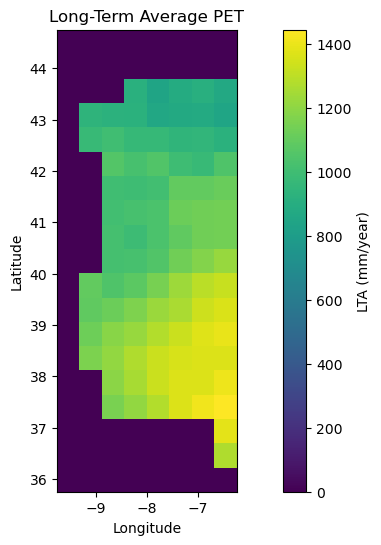

In [7]:
def read_netcdf(file_path, var_name):
    dataset = nc.Dataset(file_path)
    data = dataset.variables[var_name][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    time = dataset.variables['time'][:]
    dataset.close()
    return data, lats, lons, time

def aggregate_to_annual(data):
    # Define the number of days in each month (assuming no leap years)
    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    # Check if data has at least 12 months of data
    if data.shape[0] < 12:
        raise ValueError("Data does not have enough months to aggregate into years.")
    # Assuming data is monthly, reshape to (years, months, lat, lon)
    years = data.shape[0] // 12
    data_reshaped = data.reshape((years, 12, *data.shape[1:]))
    # Convert monthly PET from mm/day to mm/month by multiplying by the number of days in each month
    monthly_totals = data_reshaped * days_in_month[:, np.newaxis, np.newaxis]
    annual_data = np.nansum(monthly_totals, axis=1)  # Mean over months
    return annual_data

def compute_long_term_average(all_annual_data):
    # Check if all_annual_data is not empty and contains valid arrays
    if not all_annual_data:
        raise ValueError("No annual data to compute long-term average.")
    concatenated_data = np.concatenate(all_annual_data, axis=0)
    # Compute long-term average over all annual data
    if concatenated_data.size == 0:
        raise ValueError("Concatenated data is empty.")
    lta = np.nanmean(concatenated_data, axis=0)
    return lta

def visualize_data(data, lats, lons, title):
    # Create a figure
    plt.figure(figsize=(12, 6))
    plt.imshow(data, extent=(lons.min(), lons.max(), lats.min(), lats.max()), origin='lower', cmap='viridis')
    plt.colorbar(label='LTA (mm/year)')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Define file paths and variable name
file_paths = ['C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_1991_2000crop_pet_dat.nc',
            'C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_2001_2010crop_pet_dat.nc',
            'C:/Users/35191/Desktop/Gridded_data/PET/cru_ts4_08_2011_2020crop_pet_dat.nc']

var_name = 'pet'

# Read and aggregate data
# Read and aggregate data
all_annual_data = []
for file_path in file_paths:
    data, lats, lons, time = read_netcdf(file_path, var_name)
    print(f"Loaded data from {file_path} with shape: {data.shape}")
    try:
        annual_data = aggregate_to_annual(data)
        print(f"Aggregated annual data with shape: {annual_data.shape}")
        all_annual_data.append(annual_data)
    except ValueError as e:
        print(f"Error processing file {file_path}: {e}")

# Compute long-term average (LTA)
try:
    lta = compute_long_term_average(all_annual_data)
    print(f"Long-term average calculated with shape: {lta.shape}")
    # Visualize the long-term average
    visualize_data(lta, lats, lons, 'Long-Term Average PET')
except ValueError as e:
    print(f"Error computing long-term average: {e}")

In [8]:
def save_as_netcdf(data, lats, lons, output_path):
    # Create a new NetCDF file
    with nc.Dataset(output_path, 'w', format='NETCDF4') as ds:
        # Create dimensions
        lat_dim = ds.createDimension('lat', len(lats))
        lon_dim = ds.createDimension('lon', len(lons))
        
        # Create variables
        lat_var = ds.createVariable('lat', 'f4', ('lat',))
        lon_var = ds.createVariable('lon', 'f4', ('lon',))
        data_var = ds.createVariable('LTAPet', 'f4', ('lat', 'lon',), fill_value=np.nan)
        
        # Set variable attributes
        lat_var.units = 'degrees_north'
        lon_var.units = 'degrees_east'
        data_var.units = 'mm/day'
        data_var.long_name = 'Long-Term Average PET'
        
        # Write data to variables
        lat_var[:] = lats
        lon_var[:] = lons
        data_var[:, :] = data
        
        # Add global attributes
        ds.title = 'Long-Term Average PET Data'
        ds.institution = 'IST'
        ds.source = 'Processed from multiple NetCDF files'

# Example usage
#output_path = 'C:/Users/35191/Desktop/Gridded_data/PET/LTA_pet_mm_year1.nc'
save_as_netcdf(lta, lats, lons, output_path)
print(f"Saved LTA data to {output_path}")


Saved LTA data to C:/Users/35191/Desktop/Gridded_data/PET/LTA_pet_mm_year1.nc


# ARIDITY INDEX

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

In [3]:
annual_pet = 'C:/Users/35191/Desktop/Gridded_data/PET/LTA_pet_mm_year.nc'
annual_precip = 'C:/Users/35191/Desktop/Gridded_data/precipitation/LTA_pre_mm_year.nc'
              
def print_dataset_info(file_path):
    # Load the NetCDF file
    ds = nc.Dataset(file_path)
    
    # Print the dataset structure
    print(f"Variables in {file_path}:")
    for var in ds.variables:
        print(f"{var}: {ds.variables[var].dimensions} -> {ds.variables[var].shape}")
    
    # Close the dataset
    ds.close()

# Check the variable names in your datasets
print_dataset_info(annual_precip)
print_dataset_info(annual_pet)


Variables in C:/Users/35191/Desktop/Gridded_data/precipitation/LTA_pre_mm_year.nc:
lat: ('lat',) -> (19,)
lon: ('lon',) -> (8,)
LTA: ('lat', 'lon') -> (19, 8)
Variables in C:/Users/35191/Desktop/Gridded_data/PET/LTA_pet_mm_year.nc:
lat: ('lat',) -> (19,)
lon: ('lon',) -> (8,)
LTA: ('lat', 'lon') -> (19, 8)


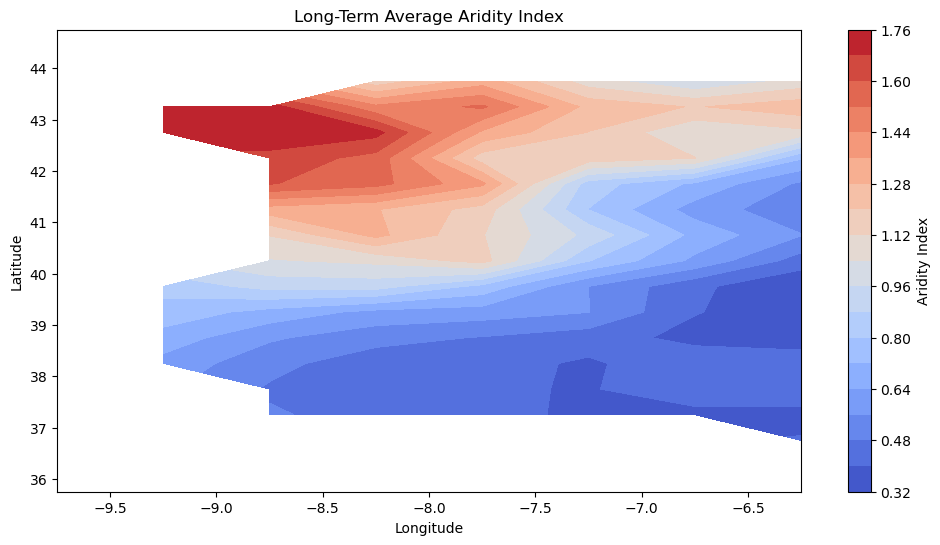

In [3]:
annual_pet = 'C:/Users/35191/Desktop/Gridded_data/PET/LTA_pet_mm_year.nc'
annual_precip = 'C:/Users/35191/Desktop/Gridded_data/precipitation/LTA_pre_mm_year.nc'
              
def aridity_index(annual_precip_path, annual_pet_path):
    # Load annual precipitation and PET data from NetCDF files
    precip_ds = nc.Dataset(annual_precip_path)
    pet_ds = nc.Dataset(annual_pet_path)

    # Assuming the variable names in NetCDF files are 'precip' and 'pet'
    annual_precip = precip_ds['LTA'][:] # Shape (years, lat, lon)
    annual_pet = pet_ds['LTA'][:]  # Shape (years, lat, lon)
    
    aridity_index = np.divide(annual_precip, annual_pet, where = annual_pet != 0)
    return aridity_index, precip_ds, pet_ds

# Function to visualize the Aridity Index for a specific year
def visualize_aridity_index(aridity_index, latitudes, longitudes):
    plt.figure(figsize=(12, 6))
    plt.contourf(longitudes, latitudes, aridity_index, cmap='coolwarm', levels=20)
    plt.colorbar(label='Aridity Index')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Long-Term Average Aridity Index')
    plt.show()

# Compute the Aridity Index
aridity_index, precip_ds, pet_ds = aridity_index(annual_precip, annual_pet)
# Extract latitude and longitude from the datasets
latitudes = precip_ds.variables['lat'][:]
longitudes = precip_ds.variables['lon'][:]

# Visualize the Aridity Index
visualize_aridity_index(aridity_index, latitudes, longitudes)

# Close the datasets
precip_ds.close()
pet_ds.close()

In [4]:
# Function to save Aridity Index to a NetCDF file
def save_aridity_index_to_netcdf(aridity_index, latitudes, longitudes, output_file):
    # Create a new NetCDF file
    with nc.Dataset(output_file, 'w', format='NETCDF4') as ds:
        # Define dimensions
        ds.createDimension('lat', len(latitudes))
        ds.createDimension('lon', len(longitudes))

        # Create variables
        lat_var = ds.createVariable('lat', 'f4', ('lat',))
        lon_var = ds.createVariable('lon', 'f4', ('lon',))
        aridity_var = ds.createVariable('aridity_index', 'f4', ('lat', 'lon'))

        # Assign data to variables
        lat_var[:] = latitudes
        lon_var[:] = longitudes
        aridity_var[:, :] = aridity_index

        # Add attributes
        lat_var.units = 'degrees_north'
        lon_var.units = 'degrees_east'
        aridity_var.units = 'dimensionless'
        aridity_var.description = 'Aridity index calculated as precipitation/PET'


output_netcdf = 'C:/Users/35191/Desktop/Gridded_data/Aridity_Index_LTA.nc'
output_image = 'C:/Users/35191/Desktop/Gridded_data/Aridity_Index_LTA.png'

# Save the Aridity Index to a NetCDF file
save_aridity_index_to_netcdf(aridity_index, latitudes, longitudes, output_netcdf)


# Extract data from rasters

In [24]:
import os
#import nctoolkit as nc
import netCDF4 as nc
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, osr
import rasterio
from rasterio.transform import from_origin
from pyproj import Transformer

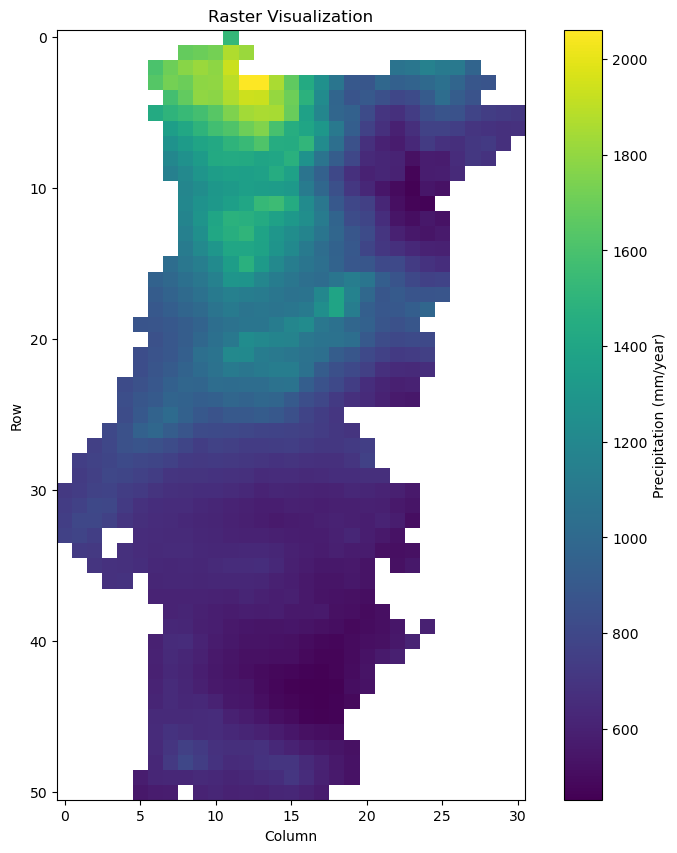

In [27]:
import os
#import nctoolkit as nc
import netCDF4 as nc
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, osr
import rasterio
from rasterio.transform import from_origin
from pyproj import Transformer
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Precip_mm_year.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Precipitation (mm/year)')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


In [30]:
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['precip_mm/year_iberia01'] = raster_values
df

,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01
0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.642212
1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.820160
2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.833008
3,3,4,512/215,-7.413606,38.052798,1.000000e-09,515.591125
4,4,5,501/63,-7.450862,38.143568,4.280313e+01,499.820160
...,...,...,...,...,...,...,...
130,130,142,263/12,-8.395251,40.011921,2.041589e+01,1066.195068
131,131,144,299/74,-8.374969,39.680614,9.906883e+01,946.539551
132,132,145,299/79,-8.387260,39.726521,7.960000e-12,946.539551
133,133,146,310/158,-8.392466,39.622033,4.120885e+02,865.891479


In [31]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone1.csv")

# ETP

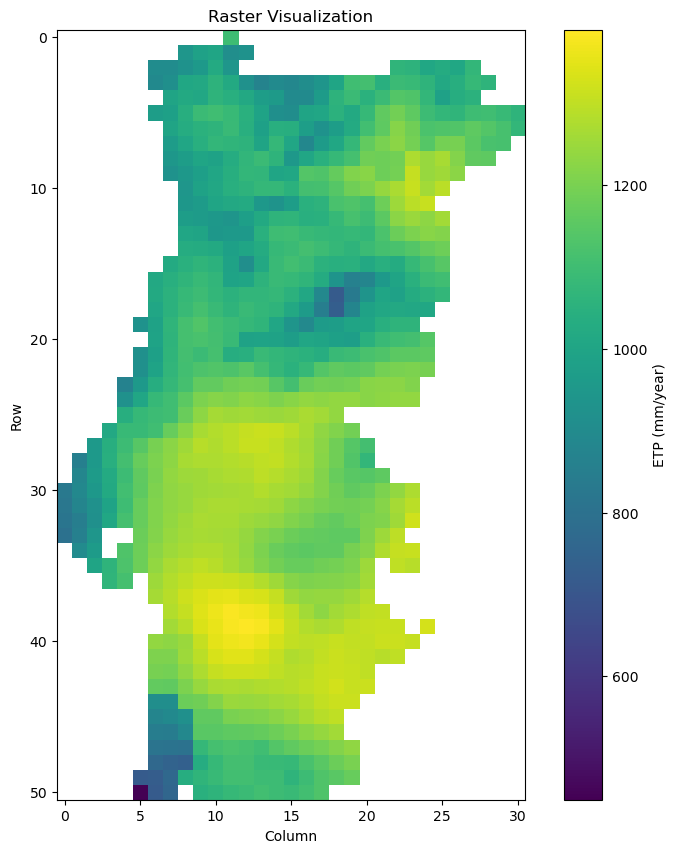

In [33]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/PET/PET_mm_year.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='ETP (mm/year)')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [34]:
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone1.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['ETP_mm/year_iberia01'] = raster_values
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01
0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.900635
1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.891479
2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.930664
3,3,3,4,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.997192
4,4,4,5,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.891479
...,...,...,...,...,...,...,...,...,...
130,130,130,142,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.642578
131,131,131,144,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.537354
132,132,132,145,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.537354
133,133,133,146,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.667480


In [35]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone1.csv")

 # Aridity Index

In [5]:
import rasterio
def print_raster_info(file_path):
    # Open the raster file
    with rasterio.open(file_path) as src:
        print(f"Information for {file_path}:")
        print(f"Driver: {src.driver}")
        print(f"Width: {src.width}")
        print(f"Height: {src.height}")
        print(f"Count (number of bands): {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Print band-specific information
        for i in range(1, src.count + 1):
            band = src.read(i)
            print(f"Band {i}:")
            print(f"  - Min value: {band.min()}")
            print(f"  - Max value: {band.max()}")
            print(f"  - Data type: {band.dtype}")

# Paths to your raster files
annual_pet = 'C:/Users/35191/Desktop/Gridded_data/PET/PET_mm_year.tif'
annual_precip = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Precip_mm_year.tif'
# Print the information
print_raster_info(annual_precip)

Information for C:/Users/35191/Desktop/Gridded_data/precipitation/Precip_mm_year.tif:
Driver: GTiff
Width: 31
Height: 51
Count (number of bands): 1
CRS: EPSG:4326
Transform: | 0.10, 0.00,-9.45|
| 0.00,-0.10, 42.15|
| 0.00, 0.00, 1.00|
Band 1:
  - Min value: -3.3999999521443642e+38
  - Max value: 2061.648193359375
  - Data type: float32


In [6]:
print_raster_info(annual_pet)

Information for C:/Users/35191/Desktop/Gridded_data/PET/PET_mm_year.tif:
Driver: GTiff
Width: 31
Height: 51
Count (number of bands): 1
CRS: EPSG:4326
Transform: | 0.10, 0.00,-9.45|
| 0.00,-0.10, 42.15|
| 0.00, 0.00, 1.00|
Band 1:
  - Min value: -3.4028234663852886e+38
  - Max value: 1389.5806884765625
  - Data type: float32


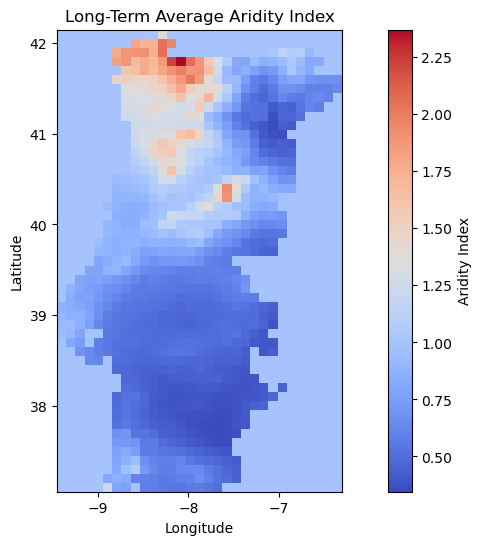

In [8]:
import numpy as np
import rasterio.plot
import matplotlib.pyplot as plt

def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        return data, transform, crs

def compute_aridity_index(annual_precip_path, annual_pet_path):
    # Read the raster data
    precip_data, precip_transform, precip_crs = read_raster(annual_precip_path)
    pet_data, pet_transform, pet_crs = read_raster(annual_pet_path)

    # Ensure the dimensions match
    if precip_data.shape != pet_data.shape:
        raise ValueError("The dimensions of the precipitation and PET rasters do not match.")

    # Compute the aridity index
    with np.errstate(divide='ignore', invalid='ignore'):
        aridity_index = np.divide(precip_data, pet_data, where=(pet_data != 0))

    return aridity_index, precip_transform, precip_crs

def visualize_aridity_index(aridity_index, transform, crs):
    plt.figure(figsize=(12, 6))
    plt.imshow(aridity_index, cmap='coolwarm', extent=rasterio.plot.plotting_extent(aridity_index, transform), origin='upper')
    plt.colorbar(label='Aridity Index')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Long-Term Average Aridity Index')
    plt.show()


def save_raster(data, transform, crs, output_path):
    # Define the metadata for the output raster
    meta = {
        'driver': 'GTiff',
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1,  # number of bands
        'dtype': data.dtype,
        'crs': crs,
        'transform': transform
    }
    
    # Write the data to a new raster file
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(data, 1)



# Paths to your raster files
annual_precip_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Precip_mm_year.tif'
annual_pet_path = 'C:/Users/35191/Desktop/Gridded_data/PET/PET_mm_year.tif'
output_aridity_index_path = 'C:/Users/35191/Desktop/Gridded_data/Aridity_index/aridity_index_iberia00001.tif'
# Compute the Aridity Index
aridity_index, transform, crs = compute_aridity_index(annual_precip_path, annual_pet_path)

# Save the Aridity Index as a raster
#save_raster(aridity_index, transform, crs, output_aridity_index_path)

# Visualize the Aridity Index
visualize_aridity_index(aridity_index, transform, crs)

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer

#Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Aridity_index/aridity_index_iberia00001.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone1.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Aridity_iberia01'] = raster_values
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Aridity_iberia01
0,0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.798827
1,1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.383918
2,2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.441755
3,3,3,3,4,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.395393
4,4,4,4,5,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.383918
...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,130,142,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.959117
131,131,131,131,144,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.776146
132,132,132,132,145,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.776146
133,133,133,133,146,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.684679


# Rainfall Seasonallity Index by Walsh and Lawler Seasonality Index (SLI)

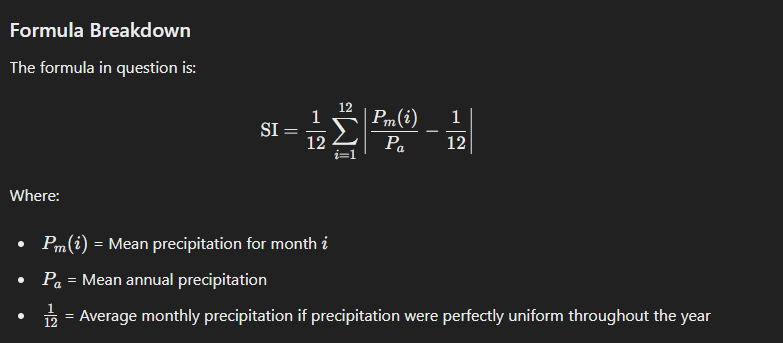

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
# List of file paths for the rasters
raster_files = ['C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month1.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month2.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month3.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month4.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month5.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month6.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month7.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month8.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month9.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month10.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month11.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month12.tif']

C:\Users\35191\.conda\envs\aiml\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


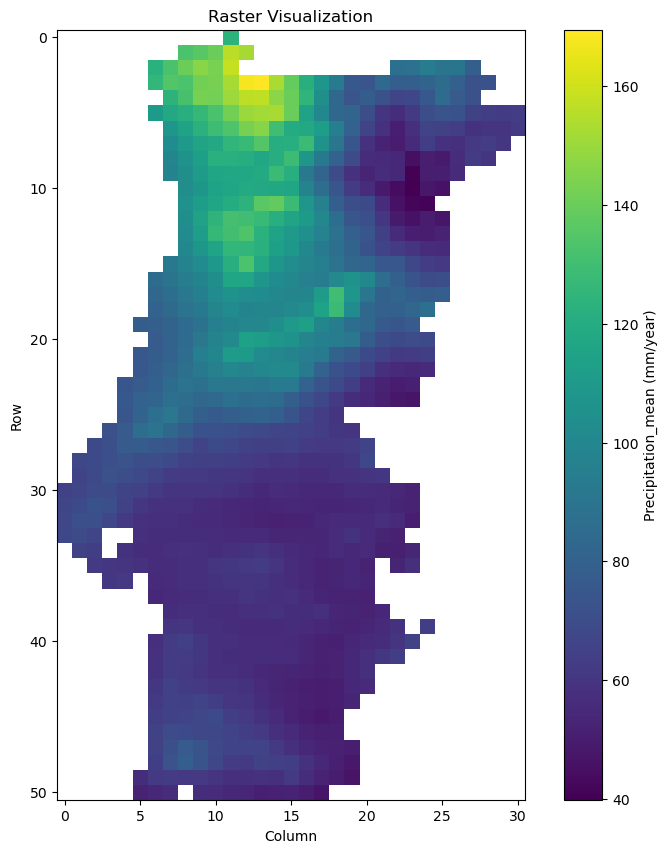

In [2]:
# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month1.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Precipitation_mean (mm/year)')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

Seasonality Index (SI) Statistics:
Min SI: 0.0
Max SI: 0.07755739134166607
Mean SI: 0.03747308983809473
Median SI: 0.06130243454351143
Standard Deviation SI: 0.032184888128705416


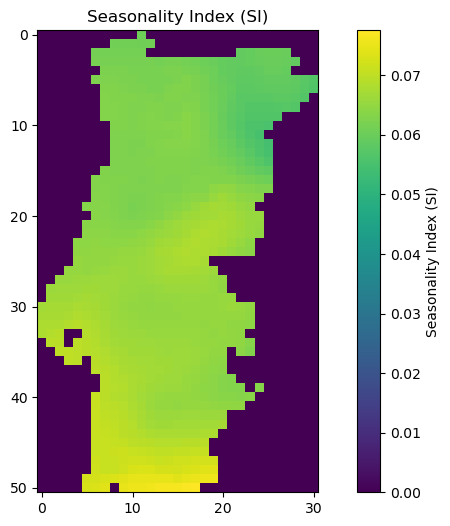

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Assuming 'raster_files' is a list of file paths to the raster data
monthly_rainfall = []

for file in raster_files:
    with rasterio.open(file) as src:
        # Read the first band and ensure the data type is appropriate (e.g., float64)
        data = src.read(1).astype(np.float64)
        monthly_rainfall.append(data)  # Read the first band

monthly_rainfall = np.stack(monthly_rainfall)

# Calculate the mean annual rainfall (sum of monthly data)
mean_annual_rainfall = np.sum(monthly_rainfall, axis=0)


# Calculate the Seasonality Index (SI)
uniform_distribution = 1 / 12
SI = (1 / 12) * np.sum(np.abs((monthly_rainfall / mean_annual_rainfall) - uniform_distribution), axis=0)
# Verify the shape of SI
if SI.ndim != 2:
    raise ValueError(f"Unexpected shape for SI: {SI.shape}. Expected 2D array.")

# Print Seasonality Index statistics
print("Seasonality Index (SI) Statistics:")
print(f"Min SI: {np.min(SI)}")
print(f"Max SI: {np.max(SI)}")
print(f"Mean SI: {np.mean(SI)}")
print(f"Median SI: {np.median(SI)}")
print(f"Standard Deviation SI: {np.std(SI)}")

# Plot Seasonality Index (SI)
plt.figure(figsize=(10, 6))
plt.imshow(SI, cmap='viridis')
plt.colorbar(label='Seasonality Index (SI)')
plt.title('Seasonality Index (SI)')
plt.show()


In [5]:
# Save the SLI as a new raster file
output_file = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Seasonality_index1.tif'
with rasterio.open(
    raster_files[0]
) as src:
    meta = src.meta
    meta.update(dtype=rasterio.float64, count=1)

with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(SI, 1)

print(f"Seasonality Index (SLI) saved as {output_file}")

Seasonality Index (SLI) saved as C:/Users/35191/Desktop/Gridded_data/precipitation/Seasonality_index1.tif


In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer

#Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Seasonality_index1.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone1.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Rainfall_Seasonality'] = raster_values
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality
0,0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306
1,1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150
2,2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540
3,3,3,3,4,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832
4,4,4,4,5,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150
...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,130,142,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095
131,131,131,131,144,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290
132,132,132,132,145,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290
133,133,133,133,146,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707


In [7]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

In [31]:
import rasterio
import numpy as np


In [32]:
raster_files = [
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month1.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month2.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month3.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month4.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month5.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month6.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month7.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month8.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month9.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month10.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month11.tif',
    'C:/Users/35191/Desktop/Gridded_data/precipitation/average_monthly_portugal/month12.tif'
]

# Load the rasters into a list of numpy arrays
monthly_rainfall = []
for file in raster_files:
    with rasterio.open(file) as src:
        monthly_rainfall.append(src.read(1))  # Assuming single-band rasters


In [33]:
annual_precipitation = np.sum(monthly_rainfall, axis=0)
mean_monthly_precipitation = annual_precipitation / 12
absolute_deviations = [np.abs(month - mean_monthly_precipitation) for month in monthly_rainfall]
sum_absolute_deviations = np.sum(absolute_deviations, axis=0)


C:\Users\35191\.conda\envs\aiml\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [34]:
index = sum_absolute_deviations / annual_precipitation


C:\Users\35191\AppData\Local\Temp\ipykernel_27360\357599127.py:1: RuntimeWarning: invalid value encountered in divide
  index = sum_absolute_deviations / annual_precipitation


In [10]:
# Assuming the same metadata as the original rasters
with rasterio.open(raster_files[0]) as src:
    meta = src.meta

meta.update(dtype=rasterio.float32)

output_file = 'C:/Users/35191/Desktop/Gridded_data/precipitation/rainfall_seasonality_index2.tif'
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(index.astype(rasterio.float32), 1)


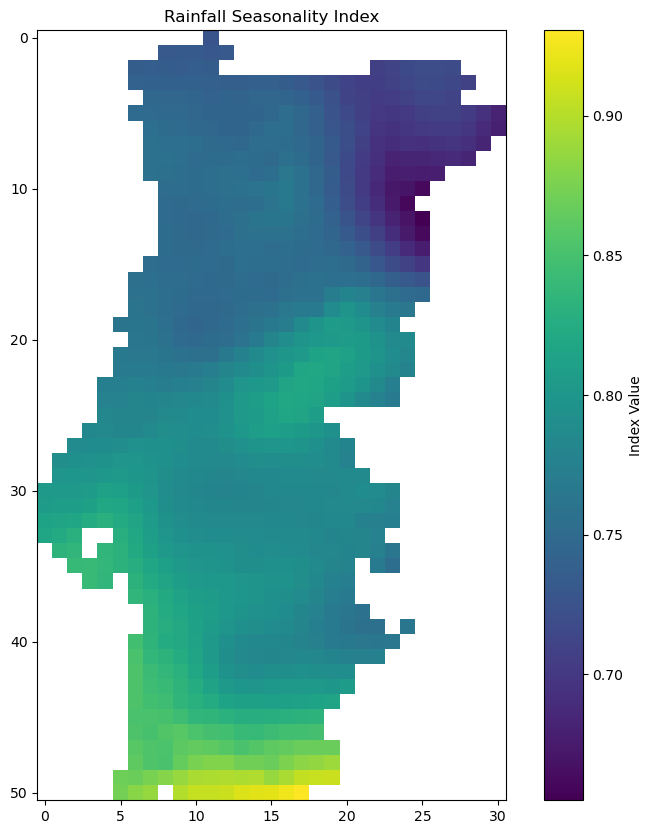

In [35]:
import rasterio
import matplotlib.pyplot as plt

# Path to the output raster file
output_file = 'C:/Users/35191/Desktop/Gridded_data/precipitation/rainfall_seasonality_index2.tif'

# Open the raster file
with rasterio.open(output_file) as src:
    index_data = src.read(1)  # Read the first (and only) band
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.title('Rainfall Seasonality Index')
    plt.imshow(index_data, cmap='viridis')
    plt.colorbar(label='Index Value')
    plt.show()


In [37]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer

#Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/rainfall_seasonality_index2.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Rainfall_Seasonality2'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,Aridity_idx,DTM,Prec_clay,Prec_sand,Prec_silt,Raster_value,Land_use_type,soil_classifcation_code,soil_classifcation,Rainfall_Seasonality2
0,-9.398529,42.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
1,-9.297059,42.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
2,-9.195588,42.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
3,-9.094118,42.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
4,-8.992647,42.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
1577,-6.658824,37.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
1578,-6.557353,37.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN
1579,-6.455882,37.1,NaN,-3.400000e+38,0.0,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-128,NaN,NaN,NaN,NaN


In [38]:
df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv")

# NDVI

In [6]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def process_ndvi(file_path, scale_factor=10000.0, fill_value=-3000):
    with rasterio.open(file_path) as src:
        # Read the NDVI data from the first band
        ndvi_data = src.read(1)
        
        # Apply the scale factor
        ndvi_data = ndvi_data / scale_factor
        
        # Handle fill values by setting them to NaN or some other placeholder
        ndvi_data[ndvi_data == fill_value] = np.nan
        
        # Plot the NDVI data
        plt.figure(figsize=(12, 6))
        plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1, extent=rasterio.plot.plotting_extent(src))
        plt.colorbar(label='NDVI')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('MODIS NDVI Data')
        plt.show()

# Path to the MODIS NDVI HDF file
ndvi_file_path = 'C:/Users/35191/Desktop/Gridded_data/NDVI/MYD13C2.A2023001.061.2023042033709.hdf'

# Process and visualize the NDVI data
process_ndvi(ndvi_file_path)


RasterioIOError: 'C:/Users/35191/Desktop/Gridded_data/NDVI/MYD13C2.A2023001.061.2023042033709.hdf' not recognized as a supported file format.

# DTM

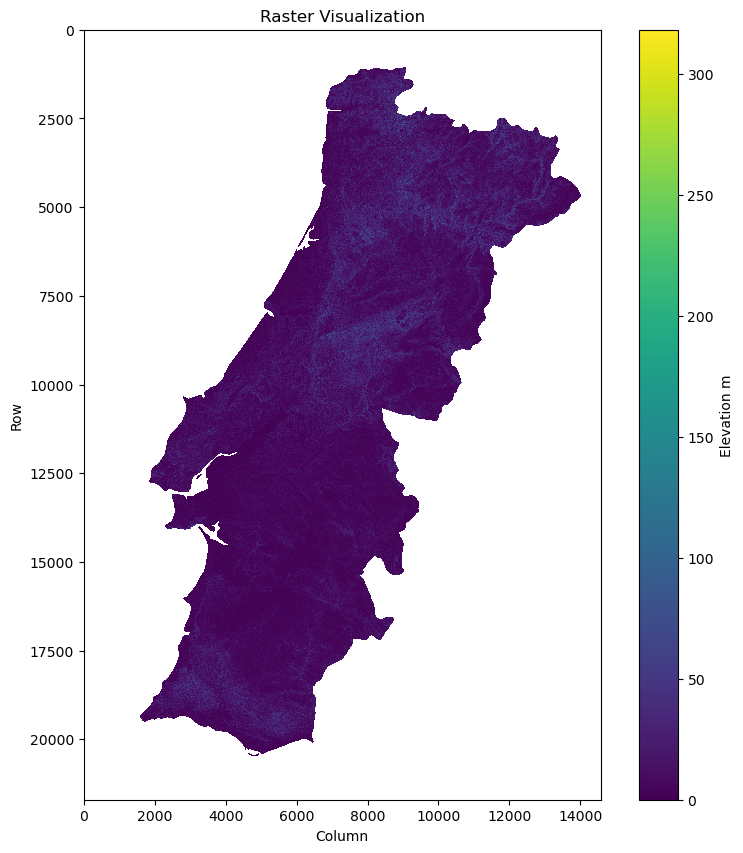

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/DTM/sloper.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Elevation m')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [ ]:
import rasterio
from scipy.ndimage import generic_filter
import numpy as np

# Function to generate a circular footprint
def generate_circular_footprint(radius):
    """Generate a circular footprint (kernel) for use with generic_filter."""
    size = radius * 2 + 1  # Diameter of the circle
    footprint = np.zeros((size, size), dtype=bool)  # Initialize an empty array
    center = radius  # Center of the circle

    for i in range(size):
        for j in range(size):
            # Calculate distance from the center
            if np.sqrt((i - center) ** 2 + (j - center) ** 2) <= radius:
                footprint[i, j] = True  # Mark cells within the radius as True
    return footprint

# Load the slope raster
with rasterio.open(raster_path) as src:
    slope = src.read(1)  # Read the first band
    profile = src.profile

# Define a function to compute the mean within a circular window
def mean_circular(values):
    return np.mean(values)

# Apply the focal filter with a circular footprint
footprint_radius = 30  # Radius in pixels (adjust based on your DEM resolution)
footprint = generate_circular_footprint(footprint_radius)
filtered_slope = generic_filter(slope, mean_circular, footprint=footprint)

# Save the resulting raster
with rasterio.open('C:/Users/35191/Desktop/Gridded_data/DTM/sloper_30m.tif', 'w', **profile) as dst:
    dst.write(filtered_slope, 1)

print("Focal statistics calculation completed. Output saved at:", 'C:/Users/35191/Desktop/Gridded_data/DTM/sloper_30m.tif')


Exception ignored in garbage collection:
Traceback (most recent call last):
  File "C:\Users\35191\AppData\Local\Temp\ipykernel_21600\1869239148.py", line 26, in mean_circular
SystemError: <function _mean_dispatcher at 0x0000014CF9401BC0> returned a result with an exception set
Exception ignored in garbage collection:
Traceback (most recent call last):
  File "C:\Users\35191\AppData\Local\Temp\ipykernel_21600\1869239148.py", line 26, in mean_circular
SystemError: <function _mean_dispatcher at 0x0000014CF9401BC0> returned a result with an exception set
Exception ignored in garbage collection:
Traceback (most recent call last):
  File "C:\Users\35191\AppData\Local\Temp\ipykernel_21600\1869239148.py", line 26, in mean_circular
SystemError: <function _mean_dispatcher at 0x0000014CF9401BC0> returned a result with an exception set
Exception ignored in garbage collection:
Traceback (most recent call last):
  File "C:\Users\35191\AppData\Local\Temp\ipykernel_21600\1869239148.py", line 26, in m

In [ ]:


# Set input parameters
input_slope_raster = 'path/to/your/slope_raster.tif'  # Path to the slope raster from Step 1
output_local_slope_raster = 'path/to/output_local_slope.tif'  # Output path for the resulting raster

# Load the input slope raster layer
slope_layer = QgsRasterLayer(input_slope_raster, 'Slope Layer')
if not slope_layer.isValid():
    print("Failed to load the slope raster.")
else:
    print("Slope raster loaded successfully.")

# Define the processing parameters for the focal statistics
params = {
    'INPUT': slope_layer,  # Input raster layer
    'BAND': 1,  # The band number of the raster (usually 1 for single-band rasters)
    'RADIUS_1': 30,  # Radius for the circular neighborhood in X direction (in map units, e.g., meters)
    'RADIUS_2': 30,  # Radius for the circular neighborhood in Y direction (in map units)
    'STATISTIC': 2,  # Statistic type (2 corresponds to 'Mean')
    'OUTPUT': output_local_slope_raster  # Path to the output file
}

# Run the SAGA Focal Statistics tool from QGIS Processing Toolbox
processing.run('saga:rasterfocalstatistics', params)

print("Focal statistics calculation completed. Output saved at:", output_local_slope_raster)


In [13]:
import rasterio
import pandas as pd
from pyproj import Transformer

# Load the CSV file
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)

# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values

# Open the raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/DTM/sloper.tif'  # Replace with your actual raster path
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Check if the transformed coordinates are NaN
        if not np.isnan(x) and not np.isnan(y):
            try:
                # Use rowcol to convert geographic coordinates to raster indices
                row, col = rasterio.transform.rowcol(transform, x, y)

                # Check if row and column indices are within raster bounds
                if 0 <= row < src.height and 0 <= col < src.width:
                    value = src.read(1)[row, col]
                    raster_values.append(value)
                else:
                    raster_values.append(None)
            except Exception as e:
                print(f"Error processing point ({x}, {y}): {e}")
                raster_values.append(None)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['sloper'] = raster_values

# Display the updated DataFrame
print(df)

      Unnamed: 0  Longitude  Latitude  Precipitation (mm/year)   PET_mm_year  \
0              0  -9.398529      42.1                      NaN -3.400000e+38   
1              1  -9.297059      42.1                      NaN -3.400000e+38   
2              2  -9.195588      42.1                      NaN -3.400000e+38   
3              3  -9.094118      42.1                      NaN -3.400000e+38   
4              4  -8.992647      42.1                      NaN -3.400000e+38   
...          ...        ...       ...                      ...           ...   
1576        1576  -6.760294      37.1                      NaN -3.400000e+38   
1577        1577  -6.658824      37.1                      NaN -3.400000e+38   
1578        1578  -6.557353      37.1                      NaN -3.400000e+38   
1579        1579  -6.455882      37.1                      NaN -3.400000e+38   
1580        1580  -6.354412      37.1                      NaN -3.400000e+38   

      Aridity_idx    DTM     Prec_clay 

In [15]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge_0_1R.csv')

In [7]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from pyproj import Transformer
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/all_variables6a.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Lat'].values
longitudes = df['Lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['sloper'] = raster_values
df

ValueError: cannot convert float NaN to integer

In [ ]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv')

In [1]:
import pandas as pd
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

# Load borehole data
boreholes = pd.read_csv('C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv')

import os

# Define paths
dem_path = os.path.join(os.getcwd(), 'C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif')
slope_path = os.path.join(os.getcwd(), 'C:/Users/35191/Desktop/Gridded_data/DTM/slopy1.tif')

# Command to compute slope in percent
cmd = f"gdaldem slope -p -compute_edges {dem_path} {slope_path}"  # The '-p' option computes slope in percent

# Execute the command using subprocess
subprocess.check_call(cmd.split())


0

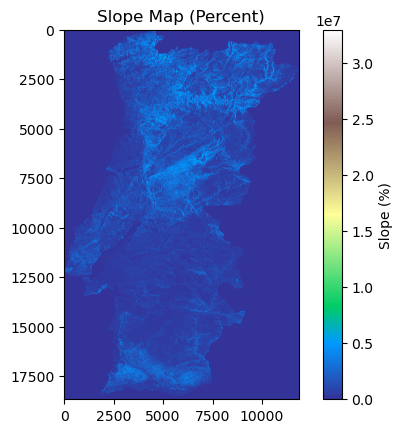

In [2]:
# Open the output slope file
slope_ds = gdal.Open(slope_path)
slope_array = slope_ds.GetRasterBand(1).ReadAsArray()

# Plotting the slope in percent
plt.imshow(slope_array, cmap='terrain')
plt.colorbar(label='Slope (%)')
plt.title('Slope Map (Percent)')
plt.show()


In [3]:
from osgeo import osr
import numpy as np

# Get geotransform and projection from the slope dataset
geotransform = slope_ds.GetGeoTransform()
projection = slope_ds.GetProjection()

# Spatial reference setup for coordinate transformation
source_srs = osr.SpatialReference()
source_srs.ImportFromWkt(projection)

# Define target spatial reference (WGS84 for lat/lon)
target_srs = osr.SpatialReference()
target_srs.ImportFromEPSG(4326)

# Coordinate transformation setup
transform = osr.CoordinateTransformation(target_srs, source_srs)

# Extract latitude and longitude from borehole data
latitudes = boreholes['lat']
longitudes = boreholes['lon']

# Calculate pixel size in meters
pixel_width = geotransform[1]  # Pixel size in X direction (meters per pixel)
pixel_height = abs(geotransform[5])  # Pixel size in Y direction (meters per pixel)

# Radius in pixels for 30 meters (assuming square pixels)
radius_in_pixels = int(30 / pixel_width)

average_slopes = []

# Loop through each borehole location
for lat, lon in zip(latitudes, longitudes):
    # Transform lat/lon to raster coordinates
    (x, y, _) = transform.TransformPoint(lon, lat)

    # Convert coordinates to pixel location
    pixel_x = int((x - geotransform[0]) / geotransform[1])
    pixel_y = int((y - geotransform[3]) / geotransform[5])

    # Initialize list to store slope values within 30m radius
    slope_values = []

    # Loop over the neighborhood pixels within the 30m radius
    for i in range(-radius_in_pixels, radius_in_pixels + 1):
        for j in range(-radius_in_pixels, radius_in_pixels + 1):
            # Compute distance from center pixel
            distance = np.sqrt(i**2 * pixel_width**2 + j**2 * pixel_height**2)
            
            if distance <= 30:  # Only consider pixels within 30 meters
                # Calculate neighboring pixel coordinates
                neighbor_x = pixel_x + i
                neighbor_y = pixel_y + j

                # Ensure that the pixel is within raster bounds
                if (0 <= neighbor_x < slope_array.shape[1]) and (0 <= neighbor_y < slope_array.shape[0]):
                    slope_value = slope_array[neighbor_y, neighbor_x]
                    if not np.isnan(slope_value):
                        slope_values.append(slope_value)

    # Calculate the average slope within the 30-meter radius
    if slope_values:
        average_slope = np.mean(slope_values)
    else:
        average_slope = None

    # Append the computed average slope to the list
    average_slopes.append(average_slope)

# Add the average slope values to the borehole DataFrame
boreholes['Average Slope (30m Radius) (%)'] = average_slopes


KeyboardInterrupt: 

In [1]:
from osgeo import gdal, ogr, osr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.mask import mask

# Load borehole data
boreholes = pd.read_csv('C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv')

# Convert boreholes DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(boreholes['lon'], boreholes['lat'])]
boreholes_gdf = gpd.GeoDataFrame(boreholes, geometry=geometry, crs='EPSG:4326')  # Assumes WGS84 CRS

# Compute the slope in degrees using gdal.DEMProcessing
dem = gdal.Open("C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif")
slope_path = "C:/Users/35191/Desktop/Gridded_data/DTM/slope21.tif"
gdal.DEMProcessing(slope_path, dem, "slope", computeEdges=True)
dem = None  # Close DEM dataset

# Open the slope raster with rasterio
with rasterio.open(slope_path) as src:
    # Reproject boreholes to the DEM's CRS
    dem_crs = src.crs
    boreholes_gdf = boreholes_gdf.to_crs(dem_crs)  # Reproject to DEM's CRS

    # Iterate over each borehole to extract slope values within a 30m radius
    slope_values = []
    for index, row in boreholes_gdf.iterrows():
        # Create a buffer around the borehole point (30m radius)
        buffer_geom = row.geometry.buffer(30)

        # Create a mask for the buffer area
        out_image, out_transform = mask(src, [buffer_geom], crop=True)
        out_image = out_image[0]  # Get the first band

        # Compute mean slope within the buffer area, ignoring no-data values
        mean_slope = np.nanmean(out_image[out_image != src.nodata])

        # Convert slope from degrees to percent
        if mean_slope is not np.nan:
            mean_slope_percent = np.tan(np.radians(mean_slope)) * 100
        else:
            mean_slope_percent = np.nan

        slope_values.append(mean_slope_percent)

# Add the slope values to the DataFrame
boreholes_gdf['Mean_Slope_30m'] = slope_values


KeyboardInterrupt: 

In [ ]:
boreholes_gdf

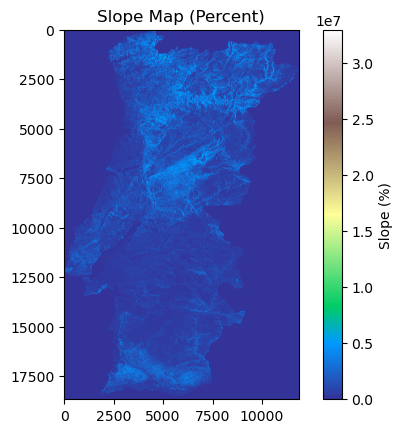

In [43]:
from osgeo import gdal
import subprocess
import os
import matplotlib.pyplot as plt

# Load the DEM
dem_path = os.path.join(os.getcwd(), 'C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif')

slope_path = os.path.join(os.getcwd(), 'C:/Users/35191/Desktop/Gridded_data/DTM/slopy.tif')

# Command to compute slope in percent
cmd = f"gdaldem slope -p -compute_edges {dem_path} {slope_path}"  # The '-p' option computes slope in percent

# Execute the command using subprocess
subprocess.check_call(cmd.split())

# Open the output slope file
slope_ds = gdal.Open(slope_path)
slope_array = slope_ds.GetRasterBand(1).ReadAsArray()

# Plotting the slope in percent
plt.imshow(slope_array, cmap='terrain')
plt.colorbar(label='Slope (%)')
plt.title('Slope Map (Percent)')
plt.show()


In [ ]:
# Save results
boreholes.to_csv('boreholes_with_slope.csv', index=False)

In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal

# Load the DEM data
dem_path = 'C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif'  # Update this path to your DEM file
dem_data = gdal.Open(dem_path)
dem_array = dem_data.ReadAsArray()

# Get georeferencing information
geotransform = dem_data.GetGeoTransform()

def latlon_to_rowcol(lat, lon, geotransform):
    # Calculate the pixel coordinates
    col = int((lon - geotransform[0]) / geotransform[1])
    row = int((lat - geotransform[3]) / geotransform[5])

    return row, col

# Load the CSV data
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)

latitudes = df['lat'].values
longitudes = df['lon'].values

# Convert lat/lon to DEM row/col
locations = [latlon_to_rowcol(lat, lon, geotransform) for lat, lon in zip(latitudes, longitudes)]

In [3]:
def calculate_slope_at_point_30m_percent(dem, row, col, resolution):
    # Calculate the elevation differences between adjacent pixels
    delta_z_x = dem[row, col+1] - dem[row, col-1] if col > 0 and col < dem.shape[1] - 1 else 0
    delta_z_y = dem[row+1, col] - dem[row-1, col] if row > 0 and row < dem.shape[0] - 1 else 0
    
    # Calculate the slope in both directions in percent
    slope_x = (delta_z_x / resolution) * 100  # Slope in percent for x direction
    slope_y = (delta_z_y / resolution) * 100  # Slope in percent for y direction
    
    # Calculate the overall slope in percent
    slope_percent = np.sqrt(slope_x**2 + slope_y**2)
    
    return slope_percent

# Calculate slope for each location
resolution = 30  # 30 meters, which is the DEM resolution
slopes_30m_percent = [calculate_slope_at_point_30m_percent(dem_array, row, col, resolution) for row, col in locations]

# Add slopes to the DataFrame
df['slope_30m_percent'] = slopes_30m_percent

# Display the DataFrame with the slopes in percent
print(df[['lat', 'lon', 'slope_30m_percent']])


           lat       lon  slope_30m_percent
0    41.746801 -7.446921           0.000000
1    38.098406 -7.438376          10.540926
2    38.036648 -7.286827          16.996732
3    38.052798 -7.413606           3.333333
4    38.143568 -7.450862          10.540926
..         ...       ...                ...
130  40.011921 -8.395251          25.385910
131  39.680614 -8.374969          52.704628
132  39.726521 -8.387260           9.428090
133  39.622033 -8.392466          18.856181
134  38.028953 -8.243388           4.714045

[135 rows x 3 columns]


In [4]:
def calculate_slope_at_point_500m_percent(dem, row, col, resolution):
    # Since resolution is 30m, 500m will correspond approximately to 16.67 pixels.
    # We will use 17 pixels (510 meters) to approximate the 500-meter distance.
    delta_z_x = dem[row, col+17] - dem[row, col-17] if col > 16 and col < dem.shape[1] - 17 else 0
    delta_z_y = dem[row+17, col] - dem[row-17, col] if row > 16 and row < dem.shape[0] - 17 else 0
    
    # Calculate the slope in both directions in percent
    slope_x = (delta_z_x / (17 * resolution)) * 100  # Slope in percent for x direction
    slope_y = (delta_z_y / (17 * resolution)) * 100  # Slope in percent for y direction
    
    # Calculate the overall slope in percent
    slope_percent = np.sqrt(slope_x**2 + slope_y**2)
    
    return slope_percent

# Calculate slope for each location
resolution = 30  # 30 meters, which is the DEM resolution
slopes_500m_percent = [calculate_slope_at_point_500m_percent(dem_array, row, col, resolution) for row, col in locations]

# Add slopes to the DataFrame
df['slope_500m_percent'] = slopes_500m_percent

# Display the DataFrame with the slopes in percent
print(df[['lat', 'lon', 'slope_500m_percent']])


           lat       lon  slope_500m_percent
0    41.746801 -7.446921            0.876889
1    38.098406 -7.438376            2.967205
2    38.036648 -7.286827           10.316036
3    38.052798 -7.413606            1.255515
4    38.143568 -7.450862           15.419297
..         ...       ...                 ...
130  40.011921 -8.395251            9.096011
131  39.680614 -8.374969           17.852831
132  39.726521 -8.387260            3.491077
133  39.622033 -8.392466            7.865165
134  38.028953 -8.243388            1.807754

[135 rows x 3 columns]


C:\Users\35191\AppData\Local\Temp\ipykernel_27824\790546137.py:5: RuntimeWarning: overflow encountered in scalar subtract
  delta_z_y = dem[row+17, col] - dem[row-17, col] if row > 16 and row < dem.shape[0] - 17 else 0
C:\Users\35191\AppData\Local\Temp\ipykernel_27824\790546137.py:4: RuntimeWarning: overflow encountered in scalar subtract
  delta_z_x = dem[row, col+17] - dem[row, col-17] if col > 16 and col < dem.shape[1] - 17 else 0


In [3]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv')

In [10]:
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Elevation'] = raster_values
df

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation
0,0,0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349
1,1,1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235
2,2,2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207
3,3,3,3,3,4,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218
4,4,4,4,4,5,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,130,130,142,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267
131,131,131,131,131,144,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192
132,132,132,132,132,145,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203
133,133,133,133,133,146,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117


In [11]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# SLOPE

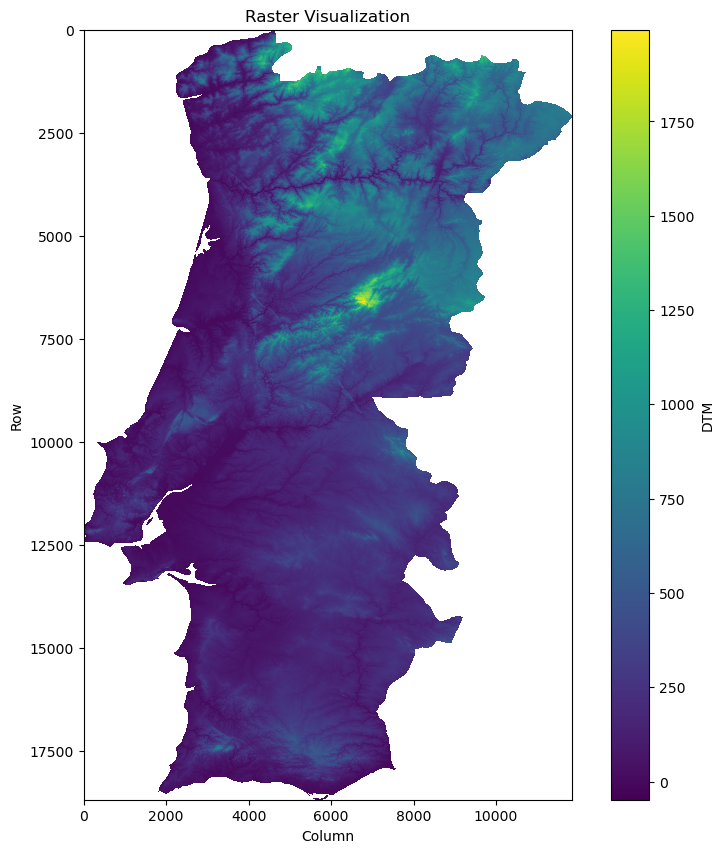

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='DTM')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

 # landcover/types mapping

In [5]:
import xml.etree.ElementTree as ET

def parse_qml(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()

    # Initialize a dictionary to hold the value to land use type mapping
    value_to_landuse = {}

    # Traverse the XML to extract the land use codes
    for element in root.findall(".//paletteEntry"):
        value = int(element.get('value'))
        label = element.get('label')
        value_to_landuse[value] = label

    return value_to_landuse

# Path to the .qml file
qml_path = 'C:/Users/35191/Desktop/Gridded_data/Corine_land_cover/Legend/Raster/clc_legend_qgis_raster.qml'

# Parse the .qml file to get the value to land use type mapping
value_to_landuse = parse_qml(qml_path)
value_to_landuse

{1: '111 - Continuous urban fabric',
 2: '112 - Discontinuous urban fabric',
 3: '121 - Industrial or commercial units',
 4: '122 - Road and rail networks and associated land',
 5: '123 - Port areas',
 6: '124 - Airports',
 7: '131 - Mineral extraction sites',
 8: '132 - Dump sites',
 9: '133 - Construction sites',
 10: '141 - Green urban areas',
 11: '142 - Sport and leisure facilities',
 12: '211 - Non-irrigated arable land',
 13: '212 - Permanently irrigated land',
 14: '213 - Rice fields',
 15: '221 - Vineyards',
 16: '222 - Fruit trees and berry plantations',
 17: '223 - Olive groves',
 18: '231 - Pastures',
 19: '241 - Annual crops associated with permanent crops',
 20: '242 - Complex cultivation patterns',
 21: '243 - Land principally occupied by agriculture with significant areas of natural vegetation',
 22: '244 - Agro-forestry areas',
 23: '311 - Broad-leaved forest',
 24: '312 - Coniferous forest',
 25: '313 - Mixed forest',
 26: '321 - Natural grasslands',
 27: '322 - Moors

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from pyproj import Transformer

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Corine_land_cover/U2018_CLC2012_V2020_20u1_raster100m/U2018_CLC2012_V2020_20u1_raster100m.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
qml_path = 'C:/Users/35191/Desktop/Gridded_data/Corine_land_cover/Legend/Raster/clc_legend_qgis_raster.qml'

df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values

# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for lon, lat in zip(longitudes, latitudes):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, lon, lat)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Raster_value'] = raster_values

# Function to parse the .qml file
def parse_qml(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()

    # Initialize a dictionary to hold the value to land use type mapping
    value_to_landuse = {}

    # Traverse the XML to extract the land use codes
    for element in root.findall(".//paletteEntry"):
        value = int(element.get('value'))
        label = element.get('label')
        value_to_landuse[value] = label

    return value_to_landuse

# Parse the .qml file to get the value to land use type mapping
value_to_landuse = parse_qml(qml_path)

# Map the raster values to land use types
df['Land_use_type'] = df['Raster_value'].map(value_to_landuse)


# Save the updated DataFrame to a new CSV file
#output_csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/updated_unconfined_monitoring_wells_cone2.csv'
#df.to_csv(output_csv_path, index=False)

# Print the first few rows of the updated DataFrame
df

,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type
0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land
1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves
2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas
3,3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves
4,4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest
131,131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...
132,132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves
133,133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub


In [10]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# Percent clay

C:\Users\35191\.conda\envs\aiml\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


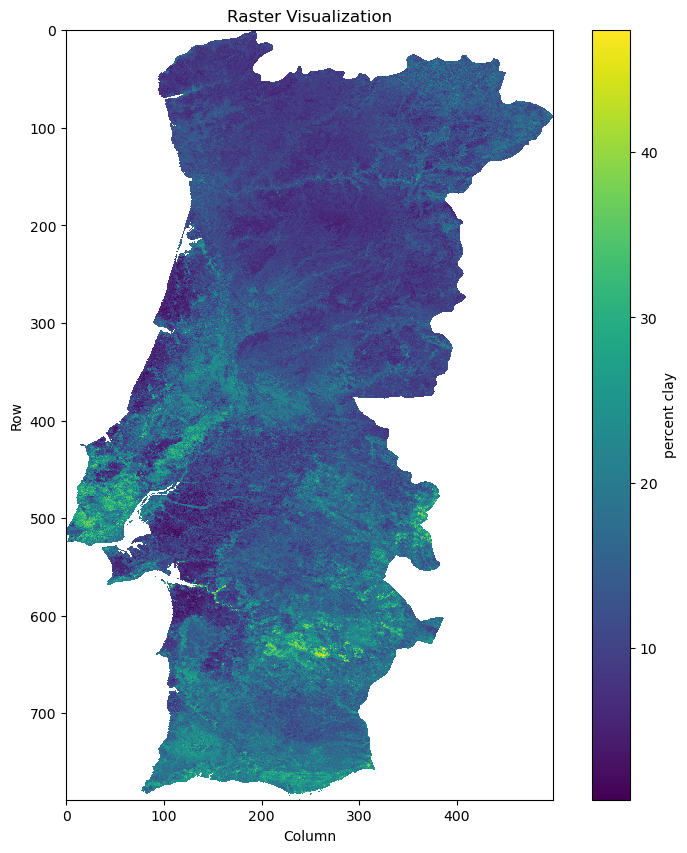

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Top_soil/Clay_EU23/clip_clay.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='percent clay')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Percent_clay'] = raster_values
df

,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type,Percent_clay
0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822
1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375
2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477
3,3,3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves,20.338989
4,4,4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223
131,131,131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896
132,132,132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves,22.878736
133,133,133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578


In [3]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# Percent sand

C:\Users\35191\.conda\envs\aiml\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


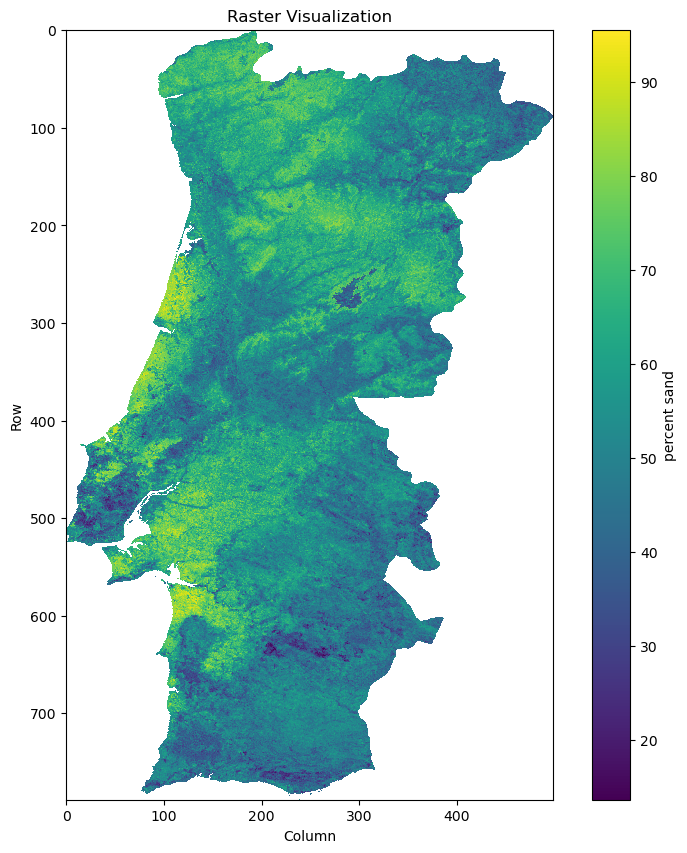

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Top_soil/Sand_EU23/clip_sand.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='percent sand')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Percent_sand'] = raster_values
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type,Percent_clay,Percent_sand
0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822,54.222443
1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375,45.764141
2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477,46.971252
3,3,3,3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves,20.338990,45.096741
4,4,4,4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899,37.805702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223,61.871441
131,131,131,131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896,48.108429
132,132,132,132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves,22.878736,40.349030
133,133,133,133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578,39.882050


In [3]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# percent silt

C:\Users\35191\.conda\envs\aiml\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


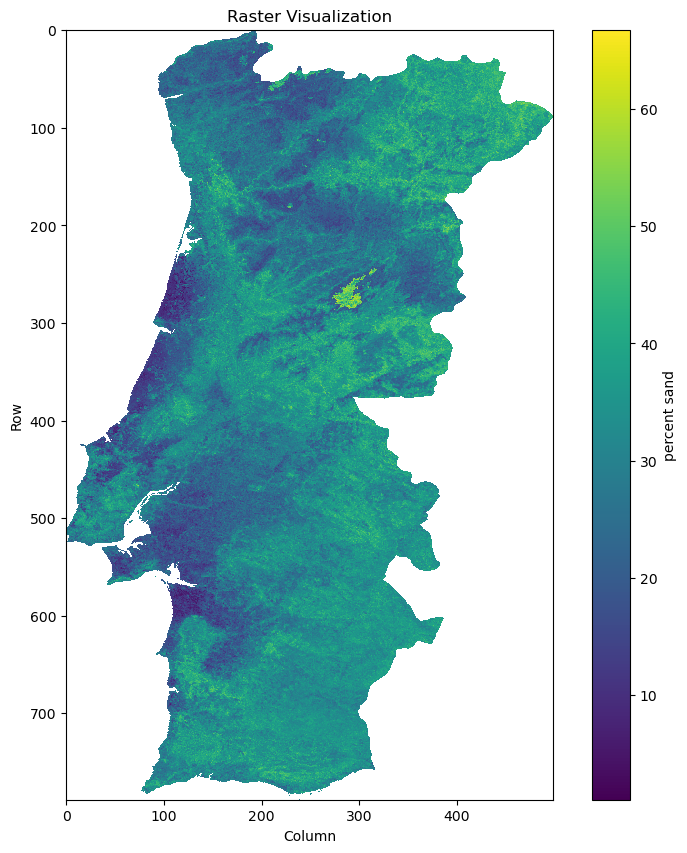

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Top_soil/Silt_EU23/clip_silt.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='percent silt')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Percent_silt'] = raster_values
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type,Percent_clay,Percent_sand,Percent_silt
0,0,0,0,0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822,54.222443,35.544739
1,1,1,1,1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375,45.764140,35.306488
2,2,2,2,2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477,46.971252,33.261269
3,3,3,3,3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves,20.338990,45.096740,34.564270
4,4,4,4,4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899,37.805702,35.340401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,130,130,130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223,61.871440,24.259338
131,131,131,131,131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896,48.108430,31.216675
132,132,132,132,132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves,22.878736,40.349030,36.772232
133,133,133,133,133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578,39.882050,36.686371


In [3]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# soil classification map of portugal

In [1]:
import geopandas as gpd

# Load the shapefile
soil_map = gpd.read_file('C:/Users/35191/Desktop/Gridded_data/soil_map/soil_class/rep_soil_map.shp')
soil_map

,AREA,PERIMETER,CODSOLO,NOME,SUBNOME,ESPECIFI,geometry
0,9.787470e+07,47854.961,704,CAMBISSOLOS,Cambissolos húmicos,rochas eruptivas,"POLYGON ((-8.33755 42.08467, -8.33552 42.08418..."
1,1.687690e+08,89036.758,401,RANKERS,Rankers,None,"POLYGON ((-8.18552 42.09406, -8.18551 42.09114..."
2,3.570954e+07,29313.652,707,CAMBISSOLOS,Cambissolos húmicos,"xistos (associados a Luvissolos, forte influên...","POLYGON ((-8.33755 42.08467, -8.30980 42.04574..."
3,2.353603e+09,568370.063,704,CAMBISSOLOS,Cambissolos húmicos,rochas eruptivas,"POLYGON ((-8.51351 42.08144, -8.50918 42.07963..."
4,3.125152e+07,98195.047,0,None,None,None,"POLYGON ((-8.51351 42.08144, -8.51502 42.07891..."
...,...,...,...,...,...,...,...
583,6.803709e+07,59377.145,715,CAMBISSOLOS,Cambissolos êutricos,rochas sedimentares post-Paleozóicas,"POLYGON ((-8.07410 37.10969, -8.06467 37.10361..."
584,1.634738e+07,28922.193,601,SOLONCHAKS,Solonchaks gleizados,None,"POLYGON ((-8.00546 37.02913, -8.00618 37.02725..."
585,8.297367e+06,49872.613,0,None,None,None,"POLYGON ((-8.00546 37.02913, -8.00605 37.03167..."
586,1.055448e+06,7078.264,601,SOLONCHAKS,Solonchaks gleizados,None,"POLYGON ((-8.03238 37.03641, -8.03277 37.03668..."


In [5]:
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv'
df = pd.read_csv(csv_path)
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
point_gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [7]:
#seting the crs to match one another
point_gdf.set_crs(soil_map.crs, inplace=True)

,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type,Percent_clay,Percent_sand,Percent_silt,Unnamed: 15,Unnamed: 16,geometry
0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822,54.222443,35.544740,NaN,NaN,POINT (-7.44692 41.74680)
1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375,45.764140,35.306488,NaN,NaN,POINT (-7.43838 38.09841)
2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477,46.971252,33.261270,NaN,NaN,POINT (-7.28683 38.03665)
3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves,20.338990,45.096740,34.564270,NaN,NaN,POINT (-7.41361 38.05280)
4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899,37.805702,35.340400,NaN,NaN,POINT (-7.45086 38.14357)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223,61.871440,24.259338,NaN,NaN,POINT (-8.39525 40.01192)
131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896,48.108430,31.216675,NaN,NaN,POINT (-8.37497 39.68061)
132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves,22.878736,40.349030,36.772232,NaN,NaN,POINT (-8.38726 39.72652)
133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578,39.882050,36.686370,NaN,NaN,POINT (-8.39247 39.62203)


In [17]:
points_with_soil = gpd.sjoin(point_gdf, soil_map[['CODSOLO', 'NOME', 'geometry']], how='left', predicate='within')
# Print the resulting GeoDataFrame with soil codes
print(points_with_soil[['lon', 'lat', 'CODSOLO', 'NOME']])

          lon        lat  CODSOLO         NOME
0   -7.446921  41.746801    104.0  FLUVISSOLOS
1   -7.438376  38.098406    804.0   LUVISSOLOS
2   -7.286827  38.036648    807.0   LUVISSOLOS
3   -7.413606  38.052798    804.0   LUVISSOLOS
4   -7.450862  38.143568    804.0   LUVISSOLOS
..        ...        ...      ...          ...
130 -8.395251  40.011921    716.0  CAMBISSOLOS
131 -8.374969  39.680614    717.0  CAMBISSOLOS
132 -8.387260  39.726521    717.0  CAMBISSOLOS
133 -8.392466  39.622033    303.0   LITOSSOLOS
134 -8.243388  38.028953    810.0   LUVISSOLOS

[135 rows x 4 columns]


In [18]:
df[['soil_classifcation_code', 'soil_classifcation']]= points_with_soil[['CODSOLO', 'NOME']]
df

,borehole_name,lon,lat,R_mm/year,precip_mm/year_iberia01,ETP_mm/year_iberia01,Aridity_index,Rainfall_Seasonality,Elevation,Terrain_slope,Raster_value,Land_use_type,Percent_clay,Percent_sand,Percent_silt,Unnamed: 15,Unnamed: 16,soil_classifcation,soil_classifcation_code
0,34/32,-7.446921,41.746801,1.788282e+02,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822,54.222443,35.544740,NaN,NaN,FLUVISSOLOS,104.0
1,512/32,-7.438376,38.098406,8.641732e+01,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375,45.764140,35.306488,NaN,NaN,LUVISSOLOS,804.0
2,524/116,-7.286827,38.036648,9.747618e+00,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477,46.971252,33.261270,NaN,NaN,LUVISSOLOS,807.0
3,512/215,-7.413606,38.052798,1.000000e-09,515.59110,1303.9972,0.395393,0.063832,218.0,89.971530,17,223 - Olive groves,20.338990,45.096740,34.564270,NaN,NaN,LUVISSOLOS,804.0
4,501/63,-7.450862,38.143568,4.280313e+01,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899,37.805702,35.340400,NaN,NaN,LUVISSOLOS,804.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,263/12,-8.395251,40.011921,2.041589e+01,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223,61.871440,24.259338,NaN,NaN,CAMBISSOLOS,716.0
131,299/74,-8.374969,39.680614,9.906883e+01,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896,48.108430,31.216675,NaN,NaN,CAMBISSOLOS,717.0
132,299/79,-8.387260,39.726521,7.960000e-12,946.53955,1219.5374,0.776146,0.065290,203.0,89.988840,17,223 - Olive groves,22.878736,40.349030,36.772232,NaN,NaN,CAMBISSOLOS,717.0
133,310/158,-8.392466,39.622033,4.120885e+02,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578,39.882050,36.686370,NaN,NaN,LITOSSOLOS,303.0


In [19]:
#df.to_csv("C:/Users/35191/Desktop/ThesisData/piezometers/unconfined_monitoring_wells_cone2.csv")

# soil maisture 

In [1]:
import os
import xarray as xr
import rioxarray
import geopandas as gpd
# wanna clip my study region to the soilmoisture netcdf file

In [2]:
import os
import xarray as xr
import rioxarray
import geopandas as gpd

def clip_netcdf_files(input_folder, output_folder, shapefile_path):
    # Load the shapefile of the study region
    print("Loading shapefile...")
    study_region = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully.")

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all NetCDF files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.nc'):
            print(f"Processing file: {file_name}")
            input_file_path = os.path.join(input_folder, file_name)
            output_file_path = os.path.join(output_folder, file_name)

            # Open the NetCDF file
            dataset = xr.open_dataset(input_file_path)

            # Force assignment of CRS (EPSG:4326)
            if 'lat' in dataset.coords and 'lon' in dataset.coords:
                print(f"Assigning CRS to file {file_name}.")
                dataset = dataset.rio.set_spatial_dims('lon', 'lat', inplace=True)
                dataset = dataset.rio.write_crs("EPSG:4326", inplace=True)

                # Clip the dataset using the study region shapefile
                clipped_dataset = dataset.rio.clip(study_region.geometry, study_region.crs, drop=True)

                # Save the clipped dataset to the output folder
                clipped_dataset.to_netcdf(output_file_path)
                print(f"Clipped file saved to {output_file_path}")
            else:
                print(f"File {file_name} does not have lat/lon coordinates and cannot be processed.")

    print("Clipping completed for all NetCDF files.")

# Define your paths
input_folder = "C:/Users/35191/Desktop/Gridded_data/soil_moisture/soil-moisture-input"
output_folder = "C:/Users/35191/Desktop/Gridded_data/soil_moisture/soil-moisture-output"
shapefile_path = "C:/Users/35191/Desktop/Thesis_Analysis/GIS/StudyArea/mainland_portugal.shp"

# Run the clipping function
clip_netcdf_files(input_folder, output_folder, shapefile_path)


Loading shapefile...
Shapefile loaded successfully.
Processing file: C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930101000000-TCDR-v202212.0.0.nc
Assigning CRS to file C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930101000000-TCDR-v202212.0.0.nc.
Clipped file saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture/soil-moisture-output\C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930101000000-TCDR-v202212.0.0.nc
Processing file: C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930201000000-TCDR-v202212.0.0.nc
Assigning CRS to file C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930201000000-TCDR-v202212.0.0.nc.
Clipped file saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture/soil-moisture-output\C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930201000000-TCDR-v202212.0.0.nc
Processing file: C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930301000000-TCDR-v202212.0.0.nc
Assigning CRS to file C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-MONTHLY-19930301000000-TCDR-v202212.0.0.nc.
Clipped file saved to C:/Users/351

In [1]:
import os
import xarray as xr
import numpy as np

def compute_yearly_and_long_term_average(input_folder, output_folder):
    # Get a list of .nc files in the input folder and sort them
    nc_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.nc')])
    
    # Determine the number of batches
    num_batches = len(nc_files) // 12

     # List to store the yearly averages
    all_yearly_averages = []
    
    for batch in range(num_batches):
        # Select the files for the current batch
        batch_files = nc_files[batch*12:(batch+1)*12]
        
        # Initialize a list to store the yearly data
        batch_data = []
        
        # Loop through each file in the batch and load the data
        for nc_file in batch_files:
            file_path = os.path.join(input_folder, nc_file)
            ds = xr.open_dataset(file_path)

            # Assuming the variable of interest is 'soil_moisture'
            batch_data.append(ds['sm'])
            
        # Compute the average soil moisture across all 12 files in the batch
        yearly_avg = xr.concat(batch_data, dim='time').mean(dim='time')
        
        # Append the yearly average to the list
        all_yearly_averages.append(yearly_avg)

        # Save the yearly average for this batch (year) to a NetCDF file
        yearly_output_file = os.path.join(output_folder, f"yearly_average_soil_moisture_year_{batch+1}.nc")
        yearly_avg.to_netcdf(yearly_output_file)
        print(f"Yearly average for year {batch+1} saved to {yearly_output_file}")
        
        
    # Compute the long-term average across all yearly averages
    long_term_avg = xr.concat(all_yearly_averages, dim='year').mean(dim='year')
    
    # Save the long-term average to a new NetCDF file
    long_term_output_file = os.path.join(output_folder, "long_term_average_soil_moisture.nc")
    long_term_avg.to_netcdf(long_term_output_file)
    
    print(f"Long-term average soil moisture saved to {long_term_output_file}")

# Define your paths
input_folder = "C:/Users/35191/Desktop/Gridded_data/soil_moisture/soil-moisture-output"
output_folder = "C:/Users/35191/Desktop/Gridded_data/soil_moisture"

# Run the computation function
compute_yearly_and_long_term_average(input_folder, output_folder)


Yearly average for year 1 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_1.nc
Yearly average for year 2 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_2.nc
Yearly average for year 3 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_3.nc
Yearly average for year 4 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_4.nc
Yearly average for year 5 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_5.nc
Yearly average for year 6 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_6.nc
Yearly average for year 7 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_7.nc
Yearly average for year 8 saved to C:/Users/35191/Desktop/Gridded_data/soil_moisture\yearly_average_soil_moisture_year_8.nc
Yearly a

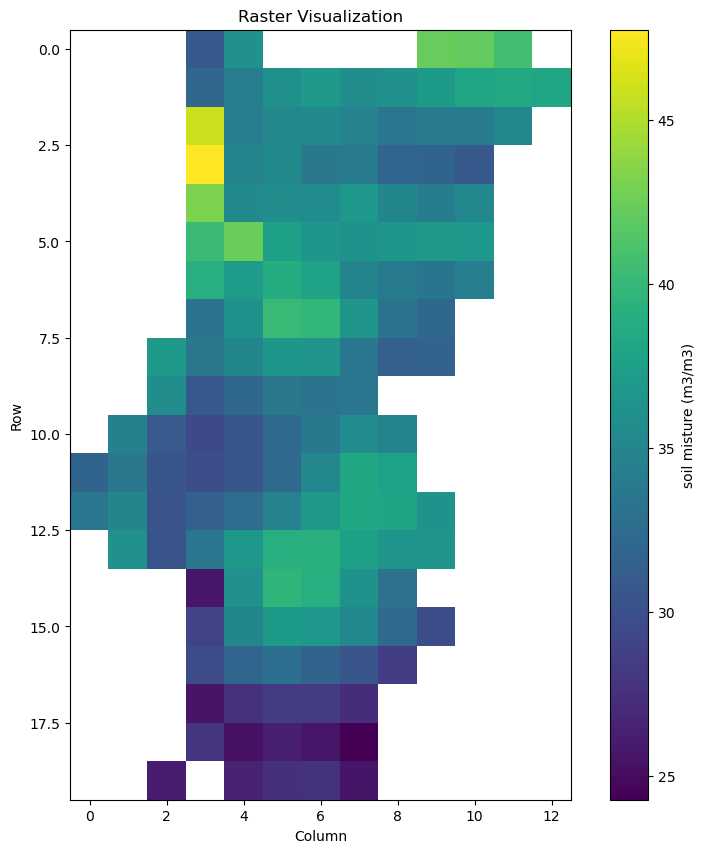

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/soil_moisture/LTA_smV.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='soil misture (m3/m3)')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/all_explan_variablesXXX.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['lat'].values
longitudes = df['lon'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['soil_moisture_m3_m3'] = raster_values
df

,borehole_name,lon,lat,Rech_co_1,Rech_co_2,precip_mm_year,ETP_mm_year,aridity_index,elevation,land_use_type,...,percent_sand,percent_silt,soil_classifcation,soil_classifcation_code,Slope_30m,Slope_100m,slope_500m,Slope_5000m,Rainfall_Seasonality2,soil_moisture_m3_m3
0,219/3,-8.408356,40.330776,NaN,1.0,1069.21100,1085.8702,0.984658,91.0,243 - Land principally occupied by agriculture...,...,49.043514,32.352036,CAMBISSOLOS,717,2.928825,5.247280,5.547492,12.647192,0.748040,37.194321
1,228/52,-8.712300,40.294612,0.771858,1.0,934.68770,1054.0730,0.886739,69.0,212 - Permanently irrigated land,...,71.482796,20.053864,PODZOIS,903,1.425283,2.207789,4.168107,4.902558,0.759074,39.128559
2,229/278,-8.666582,40.243392,0.213221,1.0,895.61194,1063.8200,0.841883,93.0,312 - Coniferous forest,...,74.322480,19.343277,CAMBISSOLOS,715,1.655054,3.431121,4.697247,6.386671,0.761298,33.264400
3,229/285,-8.666855,40.256900,0.318032,1.0,934.68770,1054.0730,0.886739,85.0,212 - Permanently irrigated land,...,83.027060,10.728027,PODZOIS,903,1.502227,1.738666,4.875282,6.134731,0.759074,39.128559
4,251/19,-8.391954,40.069197,0.568064,1.0,1045.85880,1107.4349,0.944398,264.0,221 - Vineyards,...,50.982796,36.335990,CAMBISSOLOS,717,5.504116,9.177499,16.346142,16.310310,0.748662,36.320625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,607/874,-7.799510,37.116778,NaN,1.0,607.50230,1105.2213,0.549666,119.0,223 - Olive groves,...,37.215134,39.000305,LUVISSOLOS,803,1.518347,3.192977,6.810530,9.883235,0.925135,27.751503
131,608/365,-7.698113,37.134254,0.239136,1.0,571.71100,1130.1387,0.505877,97.0,323 - Sclerophyllous vegetation,...,34.701523,38.450450,CAMBISSOLOS,718,2.252468,2.276919,5.224702,8.765383,0.930689,25.619318
132,608/367,-7.697982,37.134890,0.544136,1.0,571.71100,1130.1387,0.505877,99.0,323 - Sclerophyllous vegetation,...,34.701523,38.450450,CAMBISSOLOS,718,1.385533,2.566365,5.118395,8.765383,0.930689,25.619318
133,608/437,-7.721542,37.130283,NaN,NaN,571.71100,1130.1387,0.505877,118.0,241 - Annual crops associated with permanent c...,...,28.401398,43.619100,LUVISSOLOS,803,1.050154,4.483253,6.665124,9.324407,0.930689,25.619318


In [7]:
#df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/all_explan_XXX.csv')

# Reprojecting rasters

In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# File paths
input_file = "C:/Users/35191/Desktop/hadi_file/burt_evy20221a.tif"
output_file = "C:/Users/35191/Desktop/hadi_file/burt_evy20221a_reprojected1.tif"

# Open the input raster file
with rasterio.open(input_file) as src:
    # Define the target CRS
    target_crs = 'EPSG:3763'

    # Calculate the transform and metadata for the reprojected raster
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Perform the reprojection
    with rasterio.open(output_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

print("Reprojection complete. The reprojected file is saved as:", output_file)


Reprojection complete. The reprojected file is saved as: C:/Users/35191/Desktop/hadi_file/burt_evy20221a_reprojected1.tif


# collecting all dataset at 0.1 resolutions

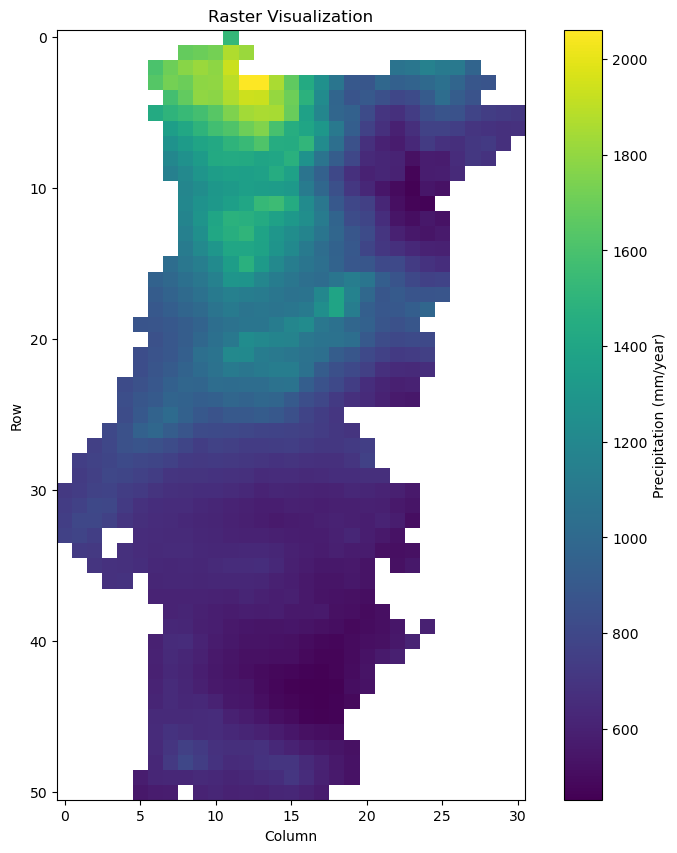

In [1]:
import os
#import nctoolkit as nc
import netCDF4 as nc
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, osr
import rasterio
from rasterio.transform import from_origin
from pyproj import Transformer
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/precipitation/Precip_mm_year.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Precipitation (mm/year)')
plt.title('Raster Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [6]:
# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the metadata
    metadata = src.meta

    # Get the transform matrix and CRS
    transform = src.transform
    crs = src.crs

    # Initialize transformer to convert to WGS84 (EPSG:4326)
    transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

    # Check for NoData values
    nodata = src.nodata
    if nodata is not None:
        # Mask NoData values
        raster_data = np.ma.masked_equal(raster_data, nodata)

    # Get the dimensions of the raster
    rows, cols = raster_data.shape

    # Create arrays to store the coordinates and values
    latitudes = []
    longitudes = []
    values = []

    # Loop over each cell in the raster
    for row in range(rows):
        for col in range(cols):
            # Calculate the coordinates of the cell center in the native CRS
            x, y = transform * (col + 0.5, row + 0.5)

            # Transform coordinates to WGS84
            lon, lat = transformer.transform(x, y)

            # Append the coordinates and the precipitation value
            latitudes.append(lat)
            longitudes.append(lon)
            values.append(raster_data[row, col])

# Create a DataFrame with the extracted values and coordinates
df = pd.DataFrame({'Longitude': longitudes, 'Latitude': latitudes, 'Precipitation (mm/year)': values})

# Optional: Save to CSV
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [4]:
df

,Longitude,Latitude,Precipitation (mm/year)
0,-9.398529,42.1,--
1,-9.297059,42.1,--
2,-9.195588,42.1,--
3,-9.094118,42.1,--
4,-8.992647,42.1,--
...,...,...,...
1576,-6.760294,37.1,--
1577,-6.658824,37.1,--
1578,-6.557353,37.1,--
1579,-6.455882,37.1,--


In [7]:
raster_path='C:/Users/35191/Desktop/Gridded_data/PET/PET_mm_year.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['PET_mm_year'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year
0,-9.398529,42.1,NaN,-3.402823e+38
1,-9.297059,42.1,NaN,-3.402823e+38
2,-9.195588,42.1,NaN,-3.402823e+38
3,-9.094118,42.1,NaN,-3.402823e+38
4,-8.992647,42.1,NaN,-3.402823e+38
...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38
1577,-6.658824,37.1,NaN,-3.402823e+38
1578,-6.557353,37.1,NaN,-3.402823e+38
1579,-6.455882,37.1,NaN,-3.402823e+38


In [8]:
# Optional: Save to CSV
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [9]:
raster_path='C:/Users/35191/Desktop/Gridded_data/DTM/DTM.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['DTM'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM
0,-9.398529,42.1,NaN,-3.402823e+38,-32768
1,-9.297059,42.1,NaN,-3.402823e+38,-32768
2,-9.195588,42.1,NaN,-3.402823e+38,-32768
3,-9.094118,42.1,NaN,-3.402823e+38,-32768
4,-8.992647,42.1,NaN,-3.402823e+38,-32768
...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768


In [10]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [11]:
raster_path='C:/Users/35191/Desktop/Gridded_data/Top_soil/Clay_EU23/clip_clay.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Prec_clay'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38
...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38


In [12]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [13]:
raster_path='C:/Users/35191/Desktop/Gridded_data/Top_soil/Sand_EU23/clip_sand.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Prec_sand'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay,Prec_sand
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38


In [14]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [15]:
raster_path='C:/Users/35191/Desktop/Gridded_data/Top_soil/Silt_EU23/clip_silt.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values


# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS if necessary
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for x, y in zip(x_trans, y_trans):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, x, y)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Prec_silt'] = raster_values
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay,Prec_sand,Prec_silt
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
...,...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38


In [16]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from pyproj import Transformer

# Path to your raster file
raster_path = 'C:/Users/35191/Desktop/Gridded_data/Corine_land_cover/U2018_CLC2012_V2020_20u1_raster100m/U2018_CLC2012_V2020_20u1_raster100m.tif'
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
qml_path = 'C:/Users/35191/Desktop/Gridded_data/Corine_land_cover/Legend/Raster/clc_legend_qgis_raster.qml'

df = pd.read_csv(csv_path)
# Ensure CSV has 'latitude' and 'longitude' columns
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values

# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster's affine transform and CRS
    transform = src.transform
    raster_crs = src.crs

    # Transform coordinates to raster CRS
    transformer = Transformer.from_crs("epsg:4326", raster_crs, always_xy=True)
    x_trans, y_trans = transformer.transform(longitudes, latitudes)

    # Extract raster values at the given coordinates
    raster_values = []
    for lon, lat in zip(longitudes, latitudes):
        # Use rowcol to convert geographic coordinates to raster indices
        row, col = rasterio.transform.rowcol(transform, lon, lat)
        
        # Check if row and column indices are within raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            value = src.read(1)[row, col]
            raster_values.append(value)
        else:
            raster_values.append(None)

# Add the raster values to the DataFrame as a new column
df['Raster_value'] = raster_values

# Function to parse the .qml file
def parse_qml(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()

    # Initialize a dictionary to hold the value to land use type mapping
    value_to_landuse = {}

    # Traverse the XML to extract the land use codes
    for element in root.findall(".//paletteEntry"):
        value = int(element.get('value'))
        label = element.get('label')
        value_to_landuse[value] = label

    return value_to_landuse

# Parse the .qml file to get the value to land use type mapping
value_to_landuse = parse_qml(qml_path)

# Map the raster values to land use types
df['Land_use_type'] = df['Raster_value'].map(value_to_landuse)


# Save the updated DataFrame to a new CSV file
#output_csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/updated_unconfined_monitoring_wells_cone2.csv'
#df.to_csv(output_csv_path, index=False)

# Print the first few rows of the updated DataFrame
df

,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay,Prec_sand,Prec_silt,Raster_value,Land_use_type
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
...,...,...,...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN


In [22]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)

In [23]:
import geopandas as gpd

# Load the shapefile
soil_map = gpd.read_file('C:/Users/35191/Desktop/Gridded_data/soil_map/soil_class/rep_soil_map.shp')
soil_map


,AREA,PERIMETER,CODSOLO,NOME,SUBNOME,ESPECIFI,geometry
0,9.787470e+07,47854.961,704,CAMBISSOLOS,Cambissolos húmicos,rochas eruptivas,"POLYGON ((-8.33755 42.08467, -8.33552 42.08418..."
1,1.687690e+08,89036.758,401,RANKERS,Rankers,None,"POLYGON ((-8.18552 42.09406, -8.18551 42.09114..."
2,3.570954e+07,29313.652,707,CAMBISSOLOS,Cambissolos húmicos,"xistos (associados a Luvissolos, forte influên...","POLYGON ((-8.33755 42.08467, -8.30980 42.04574..."
3,2.353603e+09,568370.063,704,CAMBISSOLOS,Cambissolos húmicos,rochas eruptivas,"POLYGON ((-8.51351 42.08144, -8.50918 42.07963..."
4,3.125152e+07,98195.047,0,None,None,None,"POLYGON ((-8.51351 42.08144, -8.51502 42.07891..."
...,...,...,...,...,...,...,...
583,6.803709e+07,59377.145,715,CAMBISSOLOS,Cambissolos êutricos,rochas sedimentares post-Paleozóicas,"POLYGON ((-8.07410 37.10969, -8.06467 37.10361..."
584,1.634738e+07,28922.193,601,SOLONCHAKS,Solonchaks gleizados,None,"POLYGON ((-8.00546 37.02913, -8.00618 37.02725..."
585,8.297367e+06,49872.613,0,None,None,None,"POLYGON ((-8.00546 37.02913, -8.00605 37.03167..."
586,1.055448e+06,7078.264,601,SOLONCHAKS,Solonchaks gleizados,None,"POLYGON ((-8.03238 37.03641, -8.03277 37.03668..."


In [24]:
import pandas as pd
csv_path = 'C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv'
df = pd.read_csv(csv_path)
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
point_gdf = gpd.GeoDataFrame(df, geometry=geometry)


In [25]:
#seting the crs to match one another
point_gdf.set_crs(soil_map.crs, inplace=True)


,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay,Prec_sand,Prec_silt,Raster_value,Land_use_type,geometry
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-9.39853 42.10000)
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-9.29706 42.10000)
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-9.19559 42.10000)
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-9.09412 42.10000)
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-8.99265 42.10000)
...,...,...,...,...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-6.76029 37.10000)
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-6.65882 37.10000)
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-6.55735 37.10000)
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,POINT (-6.45588 37.10000)


In [27]:
points_with_soil = gpd.sjoin(point_gdf, soil_map[['CODSOLO', 'NOME', 'geometry']], how='left', predicate='within')
# Print the resulting GeoDataFrame with soil codes
print(points_with_soil[['Longitude', 'Latitude', 'CODSOLO', 'NOME']])


      Longitude  Latitude  CODSOLO NOME
0     -9.398529      42.1      NaN  NaN
1     -9.297059      42.1      NaN  NaN
2     -9.195588      42.1      NaN  NaN
3     -9.094118      42.1      NaN  NaN
4     -8.992647      42.1      NaN  NaN
...         ...       ...      ...  ...
1576  -6.760294      37.1      NaN  NaN
1577  -6.658824      37.1      NaN  NaN
1578  -6.557353      37.1      NaN  NaN
1579  -6.455882      37.1      NaN  NaN
1580  -6.354412      37.1      NaN  NaN

[1581 rows x 4 columns]


In [28]:
df[['soil_classifcation_code', 'soil_classifcation']]= points_with_soil[['CODSOLO', 'NOME']]
df


,Longitude,Latitude,Precipitation (mm/year),PET_mm_year,DTM,Prec_clay,Prec_sand,Prec_silt,Raster_value,Land_use_type,soil_classifcation_code,soil_classifcation
0,-9.398529,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
1,-9.297059,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
2,-9.195588,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
3,-9.094118,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
4,-8.992647,42.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,-6.760294,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
1577,-6.658824,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
1578,-6.557353,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN
1579,-6.455882,37.1,NaN,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,NaN,NaN,NaN


In [29]:
df.to_csv('C:/Users/35191/Desktop/ThesisData/piezometers/recharge/recharge_0_1R.csv', index=False)